# 3. 第三章 - 尝试解决一个实际问题


目录：
* 3.1 加载 MNIST 数据集
* 3.2 定义模型
* 3.3 选择损失函数和优化器
* 3.4 模型训练并验证
* 3.5 可视化验证

现在，让我们依靠计图的强大力量，解决你的第一个实际问题吧！  

In [1]:
# 加载计图
import jittor as jt

# 开启 GPU 加速
jt.flags.use_cuda = 1

[i 0202 23:00:55.471709 24 compiler.py:847] Jittor(1.2.2.27) src: /home/llt/.local/lib/python3.7/site-packages/jittor
[i 0202 23:00:55.473366 24 compiler.py:848] g++ at /usr/bin/g++
[i 0202 23:00:55.474573 24 compiler.py:849] cache_path: /home/llt/.cache/jittor/default/g++
[i 0202 23:00:55.489276 24 __init__.py:257] Found /usr/local/cuda/bin/nvcc(10.2.89) at /usr/local/cuda/bin/nvcc.
[i 0202 23:00:55.567521 24 __init__.py:257] Found gdb(8.1.0) at /usr/bin/gdb.
[i 0202 23:00:55.583515 24 __init__.py:257] Found addr2line(2.30) at /usr/bin/addr2line.
[i 0202 23:00:55.632399 24 compiler.py:889] pybind_include: -I/usr/include/python3.7m -I/usr/local/lib/python3.7/dist-packages/pybind11/include
[i 0202 23:00:55.657575 24 compiler.py:891] extension_suffix: .cpython-37m-x86_64-linux-gnu.so
[i 0202 23:00:55.868891 24 __init__.py:169] Total mem: 62.78GB, using 16 procs for compiling.
[i 0202 23:00:56.064987 24 jit_compiler.cc:21] Load cc_path: /usr/bin/g++
[i 0202 23:00:56.261122 24 init.cc:54] 

## 任务：使用 Jittor 对 MNIST 手写数字进行识别

**任务描述如下：**  
* MNIST 手写数字数据库，主要收集了不同人群真实的手写数字记录（包括 0 到 9 十个数字）。该数据库包含训练集上 60,000 个示例，和测试集上 10,000 个示例。数据库详细信息可见：http://yann.lecun.com/exdb/mnist/ 


* MNIST 手写数字示例： 

<!-- ![avatar](mnist.png) -->
<!-- ![mnist.png](attachment:mnist.png) -->
<img  src="mnist.png" width=600 height=600>

* 目标：利用 Jittor 对 MNIST 手写数字进行识别，辨认出手写数字所要表达的真实数字值。


**解决步骤如下：**
1.  通过 Jittor 加载 MNIST 手写数字的 **数据集**；


2.  定义 **模型** ：设计卷积神经网络；  


3.  选择合适的 **损失函数** 和 **优化器**；  


4.  完成模型 **训练** 并 **验证** 的主代码块。  

## 3.1 加载 MNIST 数据集

由于 MNIST 是一个常见的数据集，为方便使用，其数据已经被封装进 Jittor。我们可以直接调用 MNIST 类，来加载需要的数据集。

In [2]:
from jittor.dataset.mnist import MNIST
import jittor.transform as trans

# 设置超参数 batch_size，其值代表一个批次中含有多少个数据。
batch_size = 64

# 创建 MNIST 训练集数据加载器
train_loader = MNIST(train=True, transform=trans.Resize(28)).set_attrs(batch_size=batch_size, shuffle=True)
# 创建 MNIST 测试集数据加载器
val_loader = MNIST(train=False, transform=trans.Resize(28)).set_attrs(batch_size=batch_size, shuffle=False)

为了更好地了解 MNIST 手写数字数据集，现在，我们尝试将数据进行可视化展示。  
以测试集数据为例：

inputs.shape: [64,3,28,28,]
targets.shape: [64,]


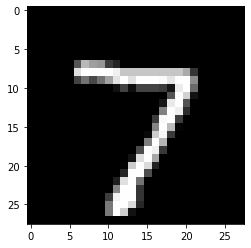

target: 7


In [3]:
import matplotlib.pyplot as plt

num = 0                                                     # 选择展示第几个 input 数据
for inputs, targets in val_loader:                          # 通过测试集加载器遍历每批次数据
    print("inputs.shape:", inputs.shape)                    # 查看 inputs 的形状
    print("targets.shape:", targets.shape)                  # 查看 targets 的形状
    
    plt.imshow(inputs[num].numpy().transpose(1, 2, 0))      # 利用 matplotlib 根据第一个 input 绘制手写数字的图像
    plt.show()                                              # 展示图像
    print("target:", targets[num].data[0])                  # 打印第一个 input 数据的真实标签值，即手写数字图像所表达的真实数字
    break

通过上述打印信息，可以看到：
* 加载器每个批次的遍历，无论是 inputs 还是 targets，都包含了 64 个数据。这与我们设置的 batch_size 相符；


* 在 inputs 中，每个数据实质为 3 个通道，每个通道包含 28\*28 个像素点的数字集合。我们可以通过 imshow() 函数画出对应的手写数字图像；


* targets 中的每个数据，实质为 1 个数字，即手写数字图像所表达的真实数字值。

## 3.2 定义模型

同样，我们需要继承 Module 类，并实现 \_\_init__ 函数和 execute 函数:

In [4]:
from jittor import nn, Module

class Model(Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv(3, 32, 3, 1)           # 卷积层 1，参数含义：该层输入通道 3，输出通道 32，卷积核大小 3*3，移动步长为 1
        self.conv2 = nn.Conv(32, 64, 3, 1)          # 卷积层 2，参数含义：该层输入通道 32，输出通道 64，卷积核大小 3*3，移动步长为 1
        self.bn = nn.BatchNorm(64)                  # 批量归一化层，参数含义：该层输入通道数为 64

        self.max_pool = nn.Pool(2, 2)               # 池化层，参数含义：窗口大小为 2，窗口移动步长为 2
        self.relu = nn.Relu()                       # 非线性激活函数 Relu
        self.fc1 = nn.Linear(64 * 12 * 12, 256)     # 线性全连接 1，参数含义：输入通道数 64*12*12（由上一步reshape变化得来），输出通道数 256
        self.fc2 = nn.Linear(256, 10)               # 线性全连接 2，参数含义：输入通道数 256，输出通道数 10
    
    def execute(self, x) :
        x = self.conv1(x)                           # 作用第一层卷积层，输入由 batch_size*3*28*28 变为输出 batch_size*32*26*26
        x = self.relu(x)                            # 通过非线性激活函数 Relu
        
        x = self.conv2(x)                           # 作用第二层卷积层，输入由 batch_size*32*26*26 变为输出 batch_size*64*24*24
        x = self.bn(x)                              # 批量归一化操作
        x = self.relu(x)                            # 通过非线性激活函数 Relu

        x = self.max_pool(x)                        # 池化操作，输入由 batch_size*64*24*24 变为输出 batch_size*64*12*12
        x = jt.reshape(x, [x.shape[0], -1])         # 将 x 压缩成只保留第一维度，输入由 batch_size*64*12*12 变为输出 batch_size*(64*12*12)
        x = self.fc1(x)                             # 作用第一层全连接，输入由 batch_size*(64*12*12) 变为输出 batch_size*256
        x = self.relu(x)                            # 通过非线性激活函数 Relu
        x = self.fc2(x)                             # 第二层全连接，并控制最后输出为 batch_size*10，每个数据的 10 个分量，分别代表十个数字的相似度
        return x


接下来，我们创建一个模型实例：

In [5]:
model = Model()

## 3.3 选择损失函数和优化器

在本次实践中，我们采用交叉熵损失函数 CrossEntropyLoss()，以及随机梯度下降 (Stochastic Gradient Descent, SGD) 作为参数优化器。  
这些常用的损失函数和优化器我们可以通过计图的 nn 类获取得到。

In [6]:
# 设置损失函数
loss_function = nn.CrossEntropyLoss()

# 设置优化器
learning_rate = 0.1
momentum = 0.9
weight_decay = 1e-4
optimizer = nn.SGD(model.parameters(), learning_rate, momentum, weight_decay)

## 3.4 模型训练并验证

In [7]:
import numpy as np

# 训练函数
def train(model, train_loader, loss_function, optimizer, epoch):
    model.train()                                                       # 开启训练模式
    train_losses = list()                                              # 初始化 Loss 容器，用于记录每一批次的 Loss
    for batch_idx, (inputs, targets) in enumerate(train_loader):       # 通过训练集加载器，按批次迭代数据
        outputs = model(inputs)                                        # 通过模型预测手写数字。outputs 中每个数据输出有 10 个分量，对应十个数字的相似度
        loss = loss_function(outputs, targets)                         # 计算损失函数
        optimizer.step(loss)                                           # 根据损失函数，对模型参数进行优化、更新
        train_losses.append(loss)                                      # 记录该批次的 Loss
        
        if batch_idx % 10 == 0:                                        # 每十个批次，打印一次训练集上的 Loss 
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    return train_losses                                                # 返回本纪元的 Loss


# 测试函数
def test(model, val_loader, loss_function, epoch):
    model.eval()                                                       # 开启训练模式
    total_correct = 0                                                  # 本纪元预测正确总次数                                
    total_num = 0                                                      # 本纪元数据总数
    for batch_idx, (inputs, targets) in enumerate(val_loader):         # 通过测试集加载器，按批次迭代数据
        outputs = model(inputs)                                        # 通过模型预测手写数字。outputs 中每个数据输出有 10 个分量，对应十个数字的相似度
        pred = np.argmax(outputs.data, axis=1)                         # 根据 10 个分量，选择最大相似度的为预测的数字值
        correct = np.sum(targets.data==pred)                           # 计算本批次中，正确预测的次数，即数据标签等于预测值的数目
        batch_size = inputs.shape[0]                                   # 计算本批次中，数据的总数目
        acc = correct / batch_size                                     # 计算本批次的正确率
        
        total_correct += correct                                       # 将本批次的正确预测次数记录到总数中
        total_num += batch_size                                        # 将本批次的数据数目记录到总数中
        
        if batch_idx % 10 == 0:                                        # 每十个批次，打印一次测试集上的准确率
            print('Test Epoch: {} [{}/{} ({:.0f}%)]\tAcc: {:.6f}'.format(epoch, \
                        batch_idx, len(val_loader),100. * float(batch_idx) / len(val_loader), acc))
    test_acc = total_correct / total_num                               # 计算本纪元的正确率
    print ('Total test acc =', test_acc)              
    return test_acc


# 设置纪元数，并开始训练和测试模型
epochs = 5
train_losses = list()
test_acc = list()
for epoch in range(epochs):
    loss = train(model, train_loader, loss_function, optimizer, epoch) # 训练模型，并返回该纪元的 Loss 列表
    train_losses += loss
    acc = test(model, val_loader, loss_function, epoch)                # 测试模型，并返回该纪元的正确率
    test_acc.append(acc)


Train Epoch: 0 [0/938 (0%)]	Loss: 2.367674
Train Epoch: 0 [10/938 (1%)]	Loss: 2.302495
Train Epoch: 0 [20/938 (2%)]	Loss: 2.215536
Train Epoch: 0 [30/938 (3%)]	Loss: 0.997462
Train Epoch: 0 [40/938 (4%)]	Loss: 0.957385
Train Epoch: 0 [50/938 (5%)]	Loss: 0.932777
Train Epoch: 0 [60/938 (6%)]	Loss: 0.419664
Train Epoch: 0 [70/938 (7%)]	Loss: 0.452631
Train Epoch: 0 [80/938 (9%)]	Loss: 0.402917
Train Epoch: 0 [90/938 (10%)]	Loss: 0.428482
Train Epoch: 0 [100/938 (11%)]	Loss: 0.604908
Train Epoch: 0 [110/938 (12%)]	Loss: 0.391322
Train Epoch: 0 [120/938 (13%)]	Loss: 0.407544
Train Epoch: 0 [130/938 (14%)]	Loss: 0.389958
Train Epoch: 0 [140/938 (15%)]	Loss: 0.894348
Train Epoch: 0 [150/938 (16%)]	Loss: 0.264137
Train Epoch: 0 [160/938 (17%)]	Loss: 0.304531
Train Epoch: 0 [170/938 (18%)]	Loss: 0.083782
Train Epoch: 0 [180/938 (19%)]	Loss: 0.360765
Train Epoch: 0 [190/938 (20%)]	Loss: 0.162649
Train Epoch: 0 [200/938 (21%)]	Loss: 0.390720
Train Epoch: 0 [210/938 (22%)]	Loss: 0.625486
Train Ep

Train Epoch: 1 [700/938 (75%)]	Loss: 0.104628
Train Epoch: 1 [710/938 (76%)]	Loss: 0.116404
Train Epoch: 1 [720/938 (77%)]	Loss: 0.059856
Train Epoch: 1 [730/938 (78%)]	Loss: 0.346445
Train Epoch: 1 [740/938 (79%)]	Loss: 0.057055
Train Epoch: 1 [750/938 (80%)]	Loss: 0.070142
Train Epoch: 1 [760/938 (81%)]	Loss: 0.148698
Train Epoch: 1 [770/938 (82%)]	Loss: 0.042575
Train Epoch: 1 [780/938 (83%)]	Loss: 0.131458
Train Epoch: 1 [790/938 (84%)]	Loss: 0.023700
Train Epoch: 1 [800/938 (85%)]	Loss: 0.268284
Train Epoch: 1 [810/938 (86%)]	Loss: 0.011392
Train Epoch: 1 [820/938 (87%)]	Loss: 0.170202
Train Epoch: 1 [830/938 (88%)]	Loss: 0.137273
Train Epoch: 1 [840/938 (90%)]	Loss: 0.100842
Train Epoch: 1 [850/938 (91%)]	Loss: 0.057559
Train Epoch: 1 [860/938 (92%)]	Loss: 0.163903
Train Epoch: 1 [870/938 (93%)]	Loss: 0.270894
Train Epoch: 1 [880/938 (94%)]	Loss: 0.110774
Train Epoch: 1 [890/938 (95%)]	Loss: 0.142618
Train Epoch: 1 [900/938 (96%)]	Loss: 0.187053
Train Epoch: 1 [910/938 (97%)]	Los

Train Epoch: 3 [320/938 (34%)]	Loss: 0.045063
Train Epoch: 3 [330/938 (35%)]	Loss: 0.058299
Train Epoch: 3 [340/938 (36%)]	Loss: 0.205273
Train Epoch: 3 [350/938 (37%)]	Loss: 0.016032
Train Epoch: 3 [360/938 (38%)]	Loss: 0.037333
Train Epoch: 3 [370/938 (39%)]	Loss: 0.089765
Train Epoch: 3 [380/938 (41%)]	Loss: 0.062916
Train Epoch: 3 [390/938 (42%)]	Loss: 0.140819
Train Epoch: 3 [400/938 (43%)]	Loss: 0.084308
Train Epoch: 3 [410/938 (44%)]	Loss: 0.223716
Train Epoch: 3 [420/938 (45%)]	Loss: 0.018608
Train Epoch: 3 [430/938 (46%)]	Loss: 0.040922
Train Epoch: 3 [440/938 (47%)]	Loss: 0.091088
Train Epoch: 3 [450/938 (48%)]	Loss: 0.100574
Train Epoch: 3 [460/938 (49%)]	Loss: 0.031961
Train Epoch: 3 [470/938 (50%)]	Loss: 0.044045
Train Epoch: 3 [480/938 (51%)]	Loss: 0.019030
Train Epoch: 3 [490/938 (52%)]	Loss: 0.056948
Train Epoch: 3 [500/938 (53%)]	Loss: 0.066515
Train Epoch: 3 [510/938 (54%)]	Loss: 0.127204
Train Epoch: 3 [520/938 (55%)]	Loss: 0.068011
Train Epoch: 3 [530/938 (57%)]	Los

Test Epoch: 4 [90/157 (57%)]	Acc: 1.000000
Test Epoch: 4 [100/157 (64%)]	Acc: 1.000000
Test Epoch: 4 [110/157 (70%)]	Acc: 1.000000
Test Epoch: 4 [120/157 (76%)]	Acc: 1.000000
Test Epoch: 4 [130/157 (83%)]	Acc: 0.984375
Test Epoch: 4 [140/157 (89%)]	Acc: 0.953125
Test Epoch: 4 [150/157 (96%)]	Acc: 0.968750
Total test acc = 0.98


## 3.5 可视化验证

模型训练完毕。最后，我们利用可视化工具，直观感受下我们的训练结果吧！

* **训练集: Loss 下降趋势**

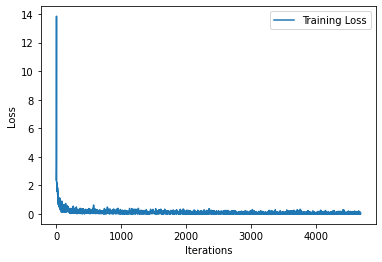

In [9]:
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

* **测试集: 正确率上升状况**

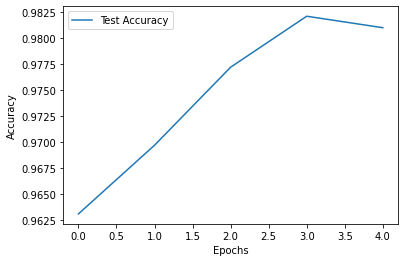

In [10]:
plt.plot(test_acc, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

* **模型预测效果**  

我们在测试集上观看一下预测效果：

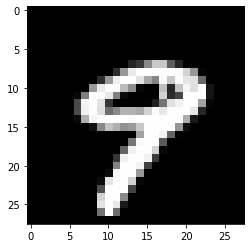

target: 9
prediction: 9


In [11]:
num = 9                                                       # 选择查看第几个数据的验证效果
for inputs, targets in val_loader:                          
    
    plt.imshow(inputs[num].numpy().transpose(1, 2, 0))        # 绘制该数据的手写数字图像
    plt.show()                                              
    
    print("target:", targets[num].data[0])                    # 打印该数据的真实标签值
    
    outputs = model(inputs)                                   # 模型根据输入数据进行预测
    pred = np.argmax(outputs.data, axis=1)                    # 根据最大相似度得到预测值
    print("prediction:", pred[num])                           # 打印该数据的预测值
    break

# 尾声 📣

恭喜您，已经完成了计图入门教程的所有内容。  
现在，您已经是一名合格的计图使用者了。  
计图官方时常会举办一些 “人工智能算法挑战赛” ，并附赠丰厚的奖金回报。作为一名合格的计图使用者，请来大赛中斩获一席之地吧！🎉🎊🎈

更多学习资料，可以参考：

*  [在线PyTorch转Jittor工具](https://cg.cs.tsinghua.edu.cn/jittor/news/2020-12-13-20-40-pt_converter/)
*  [PyTorch模型转换指南](https://cg.cs.tsinghua.edu.cn/jittor/tutorial/2020-5-2-16-43-pytorchconvert/)
*  [Jittor文档](https://cg.cs.tsinghua.edu.cn/jittor/assets/docs/index.html)
*  [Jittor模型库](https://cg.cs.tsinghua.edu.cn/jittor/resources/)
*  [Jittor教程](https://cg.cs.tsinghua.edu.cn/jittor/tutorial/)

Jittor还很年轻。 它可能存在错误和问题。 请在我们的错误跟踪系统，QQ群（761222083）中报告它们。 我们欢迎您为Jittor做出贡献。

您可以用以下方式帮助Jittor：

* 在论文中引用 Jittor
* 向身边的好朋友推荐 Jittor
* 贡献代码
* 贡献教程和文档
* 提出issue
* 回答 jittor 相关问题
* 点亮小星星
* 持续关注 jittor

[Jittor Github 地址](https://github.com/jittor/jittor), 
[Jittor Gitee 地址](https://gitee.com/jittor/jittor)

求star～您的支持是对我们最大的鼓励！

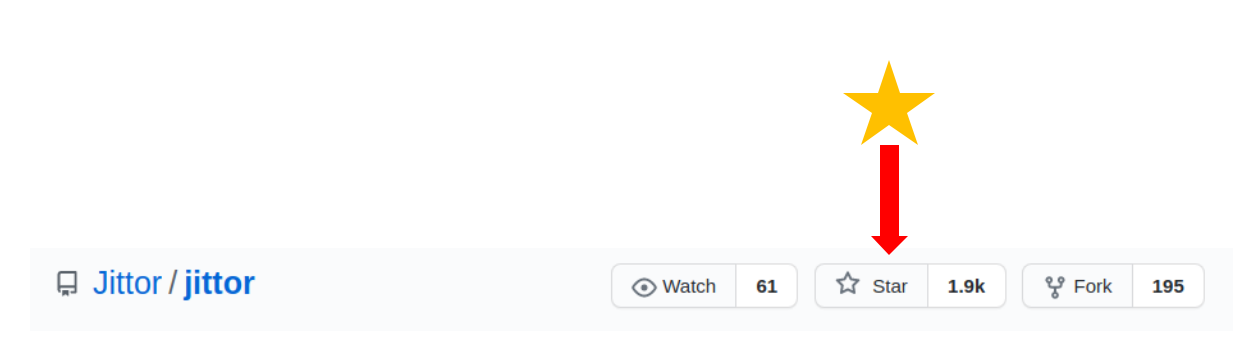

特别感谢本教程作者：llt